## Conor Sayres

### Astro 513 - problem set 2
Imports, constants and helper functions:

In [105]:
import numpy
from scipy.optimize import fsolve
import scipy.integrate
import matplotlib.pyplot as plt

########### 
#constants
###########
joule_per_ev = 1.602e-19
km_per_mpc = 3.086e+19
cm3_per_m3 = 1000000
cm2_per_m2 = 10000
mpc_per_meter = 3.24078e-23
eta = 5e-10
To = 2.7 # K
kb = 1.38064852e-23 # m^2kgs^(-2)K^(-1)
I = 13.6 * joule_per_ev # kgm^2s^(-2)
zeta = 1.202
me = 9.10938356e-31 # kg
c=299792458 # m/s
Ho = 70 / km_per_mpc # s-1
to = 1 / Ho
Omega_m = 0.3
Omega_r = 10**-4
###########

# redshift formula for temperature: T = To(1+z)

def z2T(z):
    # convert redshift to temperature
    return To*(1+z)

def T2z(T):
    # convert temperature to redshift
    return T/To - 1

## Problem 1. Hot Dark Matter
**a) Calcuate comoving distance particle can free stream after decoupling.**  For this use the conformal distance, relevant for a relativistic particle: $$d_c = \int_{z_{dc=\infty}}^{z_{nr}} \frac{cdz}{H(z)} $$
where $z_{dc}$ is the moment of decoupling and is taken to be $z = \infty$, and $z_{nr}$ is the moment when the particle becomes non-relativistic  ($k_BT = m_Hc^2$).  After the particle becomes non-relativistic, it will continue to decelerate relative to the local Hubble flow like $\frac{dv}{dt} = -H_mv$ so $v(t) = ce^{-H_mt}$, where c is the speed of light.  So the additional distance traveled after the relativistic limit will be computed like: 
$$ r_{nr} = \int_{0}^{t_o - t_{nr}}ce^{-H_mt} = \frac{c-ce^{-H_m(t_o-t_{nr})}}{H_m}$$ 

where $t_o = H_o^{-1}$, $t_{nr} = H_{nr}^{-1}$, and $H_m$ is estimated at the midpoint redshift (rather than integrated throughout) as $H_m = (H_{nr} + H_o)/2  $  so the total distance traveled will be $d_c + r_{nr}$. The math for this is coded below.

In [145]:
def invFriedmannMass(z):
    # inverted freidman in matter dominated universe, this will be integrated numerically
    return 1/(Ho*numpy.sqrt(Omega_m)*(1+z)**(3/2))

def invFriedmannRadiation(z):
    # inverted freidman in matter dominated universe, this will be integrated numerically
    return 1/(Ho*numpy.sqrt(Omega_r)*(1+z)**(2))

def comovingRelativistic(mh, massDominated=True):
    # input mass of particle, if massDominated is true, use mass dominated Friedmann
    # else use the radiation dominated Friedmann
    # return the comoving distance in Mpc
    T_nr = c**2 * mh / kb
    # convert to redshift
    z_nr = T2z(T_nr)
    # choose mass or radiation dominated Friedmann...
    feq = invFriedmannRadiation
    if massDominated:
        feq = invFriedmannMass
    # integrate it
    invF = scipy.integrate.quad(feq, z_nr, numpy.inf)[0]
    
    # convert to Mpc
    dc = invF * c * mpc_per_meter
    return dc, z_nr

def comovingNonRelativistic(z_nr, massDominated=True):
    # input z_nr the redshift at which the particle
    # becomes non-relativistic
    # integrate the additional distance traveled
    # assuming it starts at the speed of light c
    
    #select the chosen freidmann eqn
    feq = invFriedmannRadiation
    if massDominated:
        feq = invFriedmannMass
    
    # solve for time at time of non-relativistic
    t_nr = feq(z_nr)
    
    # compute the midpoint z from which to derive
    # the hubble rate
    midZ = z_nr / 2
    # find value of hubble flow at midpoint z
    H_m = feq(midZ)
    # compute additional distance traveled in mpc
    r_nr = (c - c*numpy.exp(-H_m*(to-t_nr)))/H_m * mpc_per_meter
    return r_nr
    

First I'll experiment with a range of $m_H$ values ranging from 1e-45 to 1e-25 kg, and plot the comoving distance results for a matter and radiation dominated universe.

/Users/csayres/.julia/conda/3/lib/python3.7/site-packages/ipykernel_launcher.py:21: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
/Users/csayres/.julia/conda/3/lib/python3.7/site-packages/ipykernel_launcher.py:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.


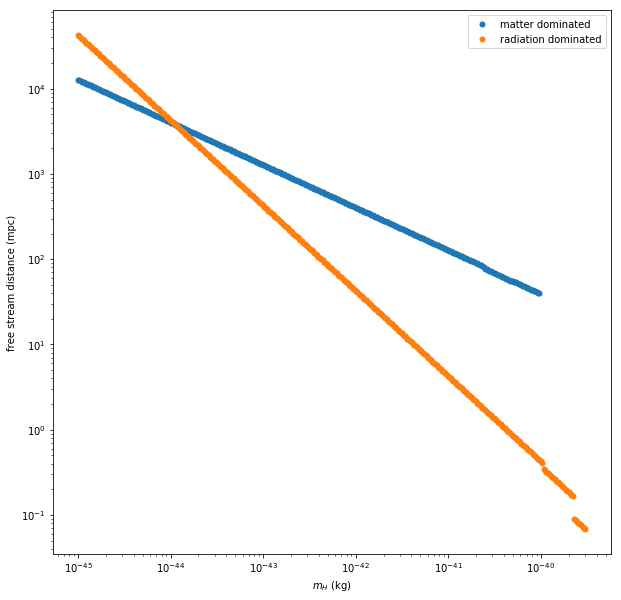

In [189]:
mhs = [] # experiment with a range of magnitudes for m_H
for magnitude in numpy.linspace(-45,-30, 1000):
    mhs.append(10**magnitude)
mhs = numpy.asarray(mhs)

# first compute distances with matter dominated freidmann
dsm = []
dsr = []
for mh in mhs:
    # matter dominated case
    dc, z_nr = comovingRelativistic(mh)
    r2 = comovingNonRelativistic(z_nr)
    dsm.append(dc+r2)

    # radiation dominated case
    dc, z_nr = comovingRelativistic(mh, massDominated=False)
    r2 = comovingNonRelativistic(z_nr, massDominated=False)
    dsr.append(dc+r2) # append total distance traveled matter dominated
dsm = numpy.asarray(dsm)
dsr = numpy.asarray(dsr)

## throw out bogus solutions from solver failures
dsm = dsm[numpy.nonzero(dsm>10**-3)]
mhm = mhs[numpy.nonzero(dsm>10**-3)]
dsr = dsr[numpy.nonzero(dsr>10**-3)]
mhr = mhs[numpy.nonzero(dsr>10**-3)]

plt.figure(figsize=(10,10))
plt.loglog(mhm, dsm, '.', markersize=10, label="matter dominated")
plt.loglog(mhr, dsr, '.', markersize=10, label="radiation dominated")
plt.xlabel("$m_H$ (kg)")
plt.ylabel("free stream distance (mpc)")
plt.legend()
plt.show()
    

Note, my integrator has some problems for specific values of $m_H$.  In HW 1 we found that the redshift at which $\Omega_m = \Omega_r$ was $z=3000$, this is the point where the matter dominated limit is most applicable.  The value of $m_H$ at z=3000 is calculated below.

In [190]:
# calculate m_H at z=3000
m_H3000 = kb * z2T(3000) / c**2
print("m_H value velow which matter dominated \nlimit is most applicable: %.2e kg"%m_H3000)

m_H value velow which matter dominated 
limit is most applicable: 1.24e-36 kg


Solving for the free streaming distances for $m_H=1.24x 10^{-36}$ kg:

In [191]:
# matter dominated case
dc, z_nr = comovingRelativistic(m_H3000)
r2 = comovingNonRelativistic(z_nr)
print("matter dominated free stream dist %.2f Mpc"%(dc+r2))

# radiation dominated case
dc, z_nr = comovingRelativistic(m_H3000, massDominated=False)
r2 = comovingNonRelativistic(z_nr, massDominated=False)
print("radiation dominated free stream dist %.2f Mpc"%(dc+r2))

matter dominated free stream dist 285.50 Mpc
radiation dominated free stream dist 142.73 Mpc


**b) Suppose this particle was the dark matter.  Use the above results to estimate the particle mass that suppresses objects of the size of dwarf galaxies ($10^{10}$ solar masses), MW ($10^{12}$ solar masses), and clusters ($10^{15}$ solar masses).**  In homework one, we solved for the radii of these galaxies, specifically I derived 0.387, 1.780, 17.8 Mpc respectively.  Lets find the values of $m_H$ in the radiation dominated universe closest to the radii for each type of structure, and plot them over the previous plot.

m_H for dwarf galaxy: 1.04e-40 kg
m_H for MW galaxy: 2.42e-41 kg
m_H for cluster: 2.39e-42 kg


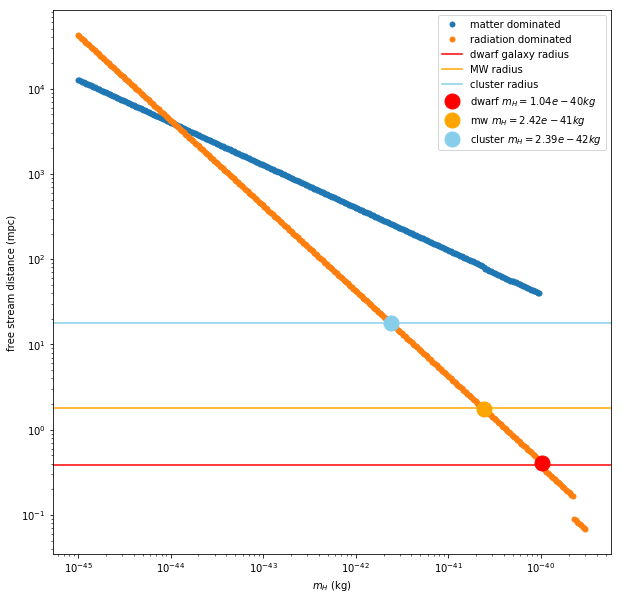

In [199]:
radii = [0.387, 1.780, 17.8]

minarg = numpy.argmin(numpy.abs(dsr-radii[0])) # find intersection for dwarf galaxy
dwarfPt = [mhr[minarg], dsr[minarg]]
print("m_H for dwarf galaxy: %.2e kg"%(mhs[minarg]))

minarg = numpy.argmin(numpy.abs(dsr-radii[1])) # find intersection for MW galaxy
mwPt = [mhr[minarg], dsr[minarg]]
print("m_H for MW galaxy: %.2e kg"%(mhs[minarg]))

minarg = numpy.argmin(numpy.abs(dsr-radii[2])) # find intersection for cluster galaxy
cPt = [mhr[minarg], dsr[minarg]]
print("m_H for cluster: %.2e kg"%(mhs[minarg]))

plt.figure(figsize=(10,10))
plt.loglog(mhm, dsm, '.', markersize=10, label="matter dominated")
plt.loglog(mhr, dsr, '.', markersize=10, label="radiation dominated")
plt.axhline(radii[0], color="red", label="dwarf galaxy radius")
plt.axhline(radii[1], color="orange", label="MW radius")
plt.axhline(radii[2], color="skyblue", label="cluster radius")
plt.loglog(dwarfPt[0], dwarfPt[1], 'o', markersize=15, color="red", label="dwarf $m_H = %.2e kg$"%dwarfPt[0])
plt.loglog(mwPt[0], mwPt[1], "o", markersize=15, color="orange", label="mw $m_H = %.2e kg$"%mwPt[0])
plt.loglog(cPt[0], cPt[1], "o", markersize=15, color="skyblue", label="cluster $m_H = %.2e kg$"%cPt[0])
plt.xlabel("$m_H$ (kg)")
plt.ylabel("free stream distance (mpc)")
plt.legend()
plt.show()

**c) Calculate $m_H$ if the particle decoupled when $g_b + 7/8g_f = 100$.**  From entropy definition in the notes:
$$
\rho = \frac{1}{2}(g_b + \frac{7}{8}g_f)a_rT^4
$$
where $\rho = \Omega_mp_{crit}$, $a_r=\frac{8\pi^5k^4}{15c^3h^3}$, $T=\frac{m_Hc^2}{k}$, $p_{crit} = \frac{3H_0^2c^2}{8\pi G}$, $g_b+7/8g_f=100$ and $\Omega_m = 0.25$.  Plugging in all these values below and solving for $m_H$ (using astropy to keep track of units):

In [232]:
from astropy import units as u
import astropy.constants
ar = 8*numpy.pi**5*(astropy.constants.k_B)**4/(15*astropy.constants.c**3*astropy.constants.h**3)
p_crit = 3 * (70*u.km/u.s/u.mpc)**2 * astropy.constants.c**2/ (8 * numpy.pi * astropy.constants.G)
mh = (0.25 * p_crit * astropy.constants.k_B**4/(50*ar*astropy.constants.c**8))**(1/4)
print("m_h = ", (mh).decompose())
print("m_h = ", (mh*astropy.constants.c**2).to(u.eV))



m_h 4.177132119024434e-35 kg
m_h 23.43199292451632 eV


This mass is *very* high!  Roughly 5 orders of magnitude greater than the suppression limits derived above for $m_H$.  And an order of magnitue above the upper limit we found for which the matter dominated limit applicable.

### Problem 2. Recombination

**a) Solve the Saha equation for $x_e(z)$, what redshift is $x_e \approx 0.1, 0.9$**

In [76]:
tGuess = z2T(1000) # solver initial guess starting temp (choose temp at redshift 1000)

def sahaT(T, x_e):
    # the saha equation, solve for T given x_e
    RHS_saha = 4 * numpy.sqrt(2)*zeta*eta/numpy.sqrt(numpy.pi) * (kb*T/(me*c**2))**(3/2) * numpy.exp(I/(kb*T))
    return RHS_saha * x_e**2 - 1 + x_e

# temperature at x_e = 0.1
x_e = 0.1
T01 = fsolve(sahaT, x0=tGuess, args=(x_e,))[0]
# convert temperature to redshift
z01 = T2z(T01)

# temperature at x_e = 0.9
x_e = 0.9
T09 = fsolve(sahaT, x0=tGuess, args=(x_e,))[0]
# convert temperature to redshift
z09 = T2z(T09)

# display answers
print("2.a results:\nx_e = 0.1 at z = %.2f\nx_e = 0.9 at z = %.2f"%(z01, z09))


2.a results:
x_e = 0.1 at z = 1266.26
x_e = 0.9 at z = 1486.64


**b) Find when the reaction rate $\Gamma$ falls below the Hubble expansion rate.**

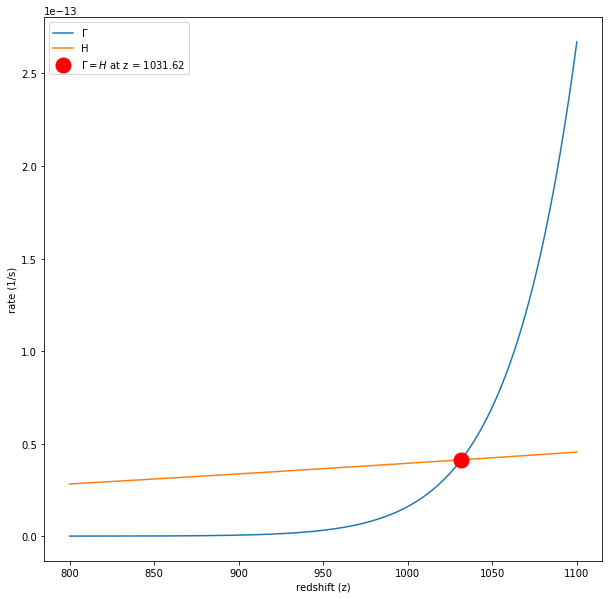

2.c results - Reaction rate equals H at:
Temp = 2788.08 K
z = 1031.62
free electron (or ionization) fraction = 6.51e-04



In [90]:
def sahaE(x_e, T):
    # saha eqn, this time solving for x_e given T
    return sahaT(T, x_e)

def nb(z):
    # return baryon number density in m^(-3)
    return 2e-7*(1+z)**3 * cm3_per_m3

def H(z):
    # return hubble rate in s^(-1)
    return Ho * numpy.sqrt(Omega_m)*(1+z)**(3/2)

def sigmaV(z):
    # return cross section times velocity in m^3/s
    # convert z to temp via redshift formula
    T = z2T(z)
    return 4.7e-24*(kb*T/(joule_per_ev))**(-1/2) * c / cm2_per_m2

def gamma(z):
    # return the reaction rate, and corresponding electron fraction
    eGuess = 0.5 # initial electron fraction guess for solver
    TList = z2T(z)
    xe = []
    for T in TList:
        # determine electron fraction for a given T from saha
        xe.append(fsolve(sahaE, x0=eGuess, args=(T,))[0])
    xe = numpy.array(xe)
    # from electron fraction get proton density given H density
    np = nb(z) * xe 
    # finally return the reaction rate gamma and the electron fraction
    return sigmaV(z) * np, xe

# plot some curves
zRange = numpy.linspace(800, 1100, 10000)
gammas, xes = gamma(zRange)
Hs = H(zRange)

plt.figure(figsize=(10,10))
plt.plot(zRange, gammas, label="$\Gamma$")
plt.plot(zRange, Hs, label="H")
plt.xlabel("redshift (z)")
plt.ylabel("rate (1/s)")
# determine the point where gamma = H and mark it
minInd = numpy.argmin(numpy.abs(gammas-Hs))
zFreeze = zRange[minInd]
gFreeze = gammas[minInd]
xeFreeze = xes[minInd]
TFreeze = z2T(zFreeze)
plt.plot(zFreeze, gFreeze, 'or', markersize=15, label="$\Gamma = H$ at z = %.2f"%zFreeze)

plt.legend()
plt.show()

# finally print results
print("2.c results - Reaction rate equals H at:\nTemp = %.2f K\nz = %.2f\nfree electron (or ionization) fraction = %.2e\n"%(TFreeze, zFreeze, xeFreeze))


**c) Estimate the residual fraction of electrons that will never recombine.** This is given above, the free electron fraction is roughly 6.51 x $10^{-4}$.

### Problem 3. The CMB
Explain qualitatively how the angular fluctuations in the CMB temperature would change if:

**a)  The Thomson scattering cross setion ($\sigma_T$) were ten times larger.**  From the lecture notes the angular size from the photon diffusion scale is given by $\theta_D = \lambda_{D,c} / r_c (z\approx10^3)$ where $\lambda_{D,c}\approx\lambda_{MFP,c}\sqrt{N_{steps}}$, $N_{steps}=cn_e\sigma_T$, and $\lambda_{MFP,c}=1/n_e\sigma_Ta$.  Combining terms we find that $\theta_D \propto \sigma_T^{-1/2}$, so by increasing $\sigma_T$ will shrink the angular size of Silk Damping.  Increasing $\sigma_T$ by a factor of 10 means the angular size $\theta_D$ will decrease by $10^{-1/2}$ which is approximately a factor of 0.32.  This means that additional temperature oscillations would be measurable out to $l_D = 2\pi / (3000x0.32)$.  Qualitatively this means that higher frequency angular modes would be observable in the CMB power spectra, before the effect of Thompson scattering completely damps the signal out.  

**b) There was no dark matter and instead all the matter, with $\Omega_{m,o}=0.3$, was in baryons.**  The Hu notes on CMB theory explain the effect of baryonic effects on the anisotropy of the CMB in 3.4.  Increasing the baryonic content of the system is analogous to adding mass to a simple spring harmonic oscillator: the amplitude of oscillation will increase, specifically the relative even-odd peaks in the CMB power spectrum will increase with increasing baryonic content. 

**c) There was an extra massless species of neutrinos.**  

**d) Reionization happened at z=100 rather than z=8**.  The scattering of CMB photons off re-ionized gas will generally suppress the anisotropies measured in the CMB, and suppression increases with photon mean free path.  In terms of redshift the mean free path of a scattered photon is $\lambda_{MFP,c}=(1+z)/n_e\sigma_T$, so the mean free path of a photon at z=100 is roughly 100 times that at z=8.  Additionally, scattering of CMB photons will become polarized resulting in a bump in the power spectrum of E-polarization on angular scales corresponding to the horizon at reionization (Hu).  This polarization bump would then be seen to shift towards a lower angular frequency in the CMB power spectrum with respect to z=8 reionization.  Measuring the polarized CMB can thus tell us something about when the epoch of reionization happened!

**e) We were able to observe in the CMB rest frame.**  We would be able to measure the true monopole and dipole of the CMB.  The dipole we observe today is due to our own peculiar velocity with respect to the CMB.  This would allow for a more exact measurement of the CMB power spectrum, especially at the low frequency end.  We would be able to determine the power in the monopole and dipole temperatures which would yield important information about the early Universe. 